# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [30]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.362301
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ As at this point the model weights are random we can expect the probabilities assigned to classes to be close to equal. As we have 10 classes this would make the model assign a probability of near 0.1 to each class, thus the loss results in -log(0.1).



In [37]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -3.379675 analytic: -3.379665, relative error: 1.527648e-06
numerical: -1.962913 analytic: -1.962851, relative error: 1.585234e-05
numerical: -2.249753 analytic: -2.250151, relative error: 8.826974e-05
numerical: -0.737637 analytic: -0.737532, relative error: 7.135415e-05
numerical: 0.184898 analytic: 0.185089, relative error: 5.144202e-04
numerical: -5.181845 analytic: -5.181391, relative error: 4.383980e-05
numerical: 1.325541 analytic: 1.325490, relative error: 1.902203e-05
numerical: 2.243194 analytic: 2.243016, relative error: 3.953090e-05
numerical: -1.856461 analytic: -1.856230, relative error: 6.226202e-05
numerical: 0.419724 analytic: 0.419934, relative error: 2.500219e-04
numerical: 1.259724 analytic: 1.258258, relative error: 5.823189e-04
numerical: -0.124663 analytic: -0.114321, relative error: 4.327538e-02
numerical: 1.560445 analytic: 1.561198, relative error: 2.411163e-04
numerical: 1.424461 analytic: 1.430256, relative error: 2.029840e-03
numerical: 1.446063 

In [54]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.362301e+00 computed in 0.159406s
vectorized loss: 2.362301e+00 computed in 0.004940s
Loss difference: 0.000000
Gradient difference: 0.000000


In [60]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-6, 5e-6, 1e-5]
regularization_strengths = [1e-4, 1e-3, 0.01, 0.1, 1, 10, 100, 1000]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        print(f"training lr: {lr}, reg: {reg}")
        classifier = Softmax()
        loss_hist = classifier.train(X_train, y_train, learning_rate=lr, reg=reg,
              num_iters=2000, verbose=True)
        
        y_train_pred = classifier.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = classifier.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        print('training accuracy: %f' % train_acc)
        print('validation accuracy: %f' % val_acc)
        
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = classifier
                            
        results[(lr, reg)] = (train_acc, val_acc)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

training lr: 1e-06, reg: 0.0001
iteration 0 / 2000: loss 5.766207
iteration 100 / 2000: loss 2.790909
iteration 200 / 2000: loss 2.333764
iteration 300 / 2000: loss 2.352495
iteration 400 / 2000: loss 2.305209
iteration 500 / 2000: loss 2.198351
iteration 600 / 2000: loss 2.051689
iteration 700 / 2000: loss 2.244981
iteration 800 / 2000: loss 1.939369
iteration 900 / 2000: loss 2.027163
iteration 1000 / 2000: loss 2.093706
iteration 1100 / 2000: loss 1.966489
iteration 1200 / 2000: loss 1.989250
iteration 1300 / 2000: loss 2.121685
iteration 1400 / 2000: loss 1.981075
iteration 1500 / 2000: loss 1.999363
iteration 1600 / 2000: loss 1.878131
iteration 1700 / 2000: loss 1.836345
iteration 1800 / 2000: loss 1.904673
iteration 1900 / 2000: loss 2.014352
training accuracy: 0.363327
validation accuracy: 0.344000
training lr: 1e-06, reg: 0.001
iteration 0 / 2000: loss 4.860925
iteration 100 / 2000: loss 2.661777
iteration 200 / 2000: loss 2.436956
iteration 300 / 2000: loss 2.271149
iteration

iteration 100 / 2000: loss 2.165170
iteration 200 / 2000: loss 2.109537
iteration 300 / 2000: loss 2.061745
iteration 400 / 2000: loss 1.898980
iteration 500 / 2000: loss 1.857053
iteration 600 / 2000: loss 1.883803
iteration 700 / 2000: loss 2.026323
iteration 800 / 2000: loss 1.946999
iteration 900 / 2000: loss 2.118220
iteration 1000 / 2000: loss 1.818092
iteration 1100 / 2000: loss 1.861115
iteration 1200 / 2000: loss 1.812109
iteration 1300 / 2000: loss 1.806296
iteration 1400 / 2000: loss 1.999269
iteration 1500 / 2000: loss 1.814574
iteration 1600 / 2000: loss 1.788431
iteration 1700 / 2000: loss 1.814090
iteration 1800 / 2000: loss 1.800149
iteration 1900 / 2000: loss 1.672684
training accuracy: 0.399980
validation accuracy: 0.378000
training lr: 5e-06, reg: 0.1
iteration 0 / 2000: loss 6.109447
iteration 100 / 2000: loss 2.353370
iteration 200 / 2000: loss 2.058109
iteration 300 / 2000: loss 2.046897
iteration 400 / 2000: loss 2.099105
iteration 500 / 2000: loss 1.927517
itera

iteration 200 / 2000: loss 3.286794
iteration 300 / 2000: loss 2.607935
iteration 400 / 2000: loss 2.716722
iteration 500 / 2000: loss 2.847726
iteration 600 / 2000: loss 2.379832
iteration 700 / 2000: loss 3.220865
iteration 800 / 2000: loss 2.849826
iteration 900 / 2000: loss 2.377039
iteration 1000 / 2000: loss 3.237883
iteration 1100 / 2000: loss 3.144185
iteration 1200 / 2000: loss 2.361588
iteration 1300 / 2000: loss 2.771650
iteration 1400 / 2000: loss 2.906618
iteration 1500 / 2000: loss 3.325748
iteration 1600 / 2000: loss 2.587850
iteration 1700 / 2000: loss 2.219269
iteration 1800 / 2000: loss 2.394528
iteration 1900 / 2000: loss 2.783176
training accuracy: 0.306061
validation accuracy: 0.268000
training lr: 1e-05, reg: 10
iteration 0 / 2000: loss 6.522731
iteration 100 / 2000: loss 3.276800
iteration 200 / 2000: loss 2.796493
iteration 300 / 2000: loss 3.335726
iteration 400 / 2000: loss 4.138577
iteration 500 / 2000: loss 3.358264
iteration 600 / 2000: loss 3.014000
iterat

In [61]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.361000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ True

$\color{blue}{\textit Your Explanation:}$
For the loss to not change for the Softmax classifier, the new data point should be evaluated in a way that the whole probability mass is given to the correct class, i.e. the model would predict the correct class with probability 1. However, for this to happen the expression $\frac{e^{f_{y_i}}}{\sum_j e^{f_j}}$ should be equal to 1 (where $f_{y_i}$ is the score of the target class and the sum iterates through all the classes), which means that the expressions $e^{f_j}$ for all classes except the target class would need to be equal to 0. This happens only when $f_j = - \infty$ and is not possible to achieve with $f_j = \mathbf{w}_j^\top \mathbf{x}$ 

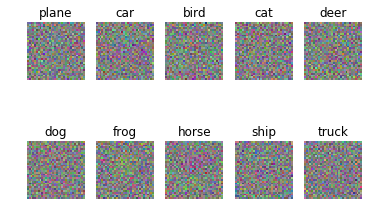

In [62]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])